In [7]:
import torch
import os
import json
import tqdm
import collections
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn.model_selection
import sklearn.decomposition
import scipy

According to Kohonen, we can do about 50 datapoints per node. For 3.5k that means maybe 60-80 nodes.
I want a 5x4 resolution for display reasons, so maybe 10x8 nodes?

In [3]:
fnames = os.listdir("data")
fields = ['name','smiles','notes']
molecules = []
for fname in tqdm.tqdm(fnames):
    with open(os.path.join("data",fname)) as f:
        mol = json.load(f)
        data = {k:mol[k] for k in fields}
        # Check that the molecule has all the fields of interest
        if all(data.values()):
            molecules.append(data)

# Have to de-dupe the notes for each molecule.
for mol in molecules:
    mol["notes"] = set(mol["notes"])
    
print(f"Found {len(molecules)} molecules.")
molecules[:3]

100%|███████████████████████████████████| 19194/19194 [00:02<00:00, 6696.21it/s]

Found 3440 molecules.


[{'name': 'amyl butyrate',
  'smiles': 'CCCCCOC(=O)CCC',
  'notes': {'banana', 'cherry', 'fruity', 'pineapple', 'sweet', 'tropical'}},
 {'name': 'para-anisyl phenyl acetate',
  'smiles': 'COC1=CC=C(C=C1)COC(=O)CC2=CC=CC=C2',
  'notes': {'anise', 'balsamic', 'honey', 'woody'}},
 {'name': 'dihydrofarnesol',
  'smiles': 'CC(CC/C=C(\\C)/CCC=C(C)C)CCO',
  'notes': {'cyclamen', 'floral', 'metallic'}}]

In [4]:
all_notes = collections.Counter()
for mol in molecules:
    all_notes.update(mol["notes"])
print(f"Found {len(all_notes)} unique notes.")
print("Most common:")
print(all_notes.most_common(5))

Found 502 unique notes.
Most common:
[('fruity', 1060), ('green', 967), ('sweet', 884), ('floral', 706), ('woody', 558)]


In [5]:
all_notes_list = list(all_notes.keys())

def multi_hot(notes):
    indices = torch.tensor([all_notes_list.index(n) for n in notes])
    if len(indices) == 0:
        # Occurs when the notes in the pair were removed due to infrequency.
        raise AttributeError("Found no valid notes.")
    one_hots = torch.nn.functional.one_hot(indices, len(all_notes))
    return one_hots.sum(dim=0).float()

for mol in molecules:
    mol["encoding"] = multi_hot(mol["notes"])

print(molecules[0])

{'name': 'amyl butyrate', 'smiles': 'CCCCCOC(=O)CCC', 'notes': {'pineapple', 'tropical', 'sweet', 'cherry', 'banana', 'fruity'}, 'encoding': tensor([1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

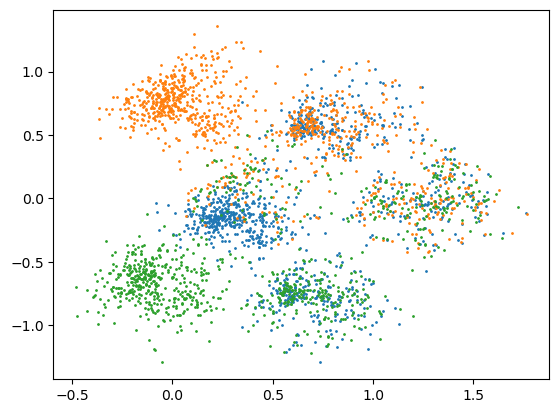

In [53]:
all_encodings = torch.stack([mol["encoding"] for mol in molecules])
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(all_encodings.numpy())
for note in ["fruity","green","sweet"]:
    pcas = []
    for i, mol in enumerate(molecules):
        if note in mol["notes"]:
            eps = 5e-2
            pcas.append(pca[i]+np.random.uniform(low=-eps, high=eps, size=2))
    pcas = np.stack(pcas)
    plt.scatter(pcas[:,0],pcas[:,1],s=1)
plt.show()

In [89]:
all_encodings = torch.stack([mol["encoding"] for mol in molecules])
pca = sklearn.decomposition.PCA(n_components=2).fit_transform(all_encodings.numpy())

def nmh(notes):
    has_fruity = 1 if "fruity" in notes else 0
    has_green = 1 if "green" in notes else 0
    has_sweet = 1 if "sweet" in notes else 0
    return [has_fruity,has_green,has_sweet]

necs = np.stack([nmh(mol["notes"]) for mol in molecules])

# Ensure that min is 0
pca = pca - [pca[:,0].min(),pca[:,1].min()]


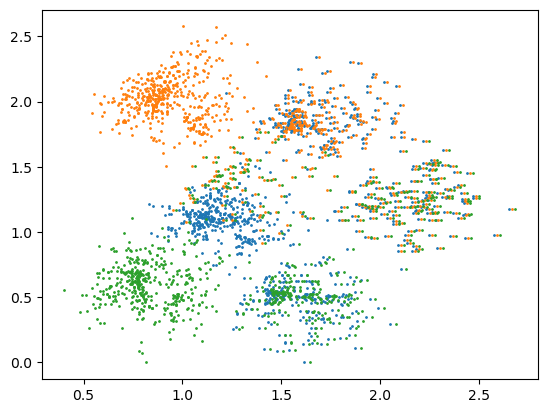

In [152]:
for x,note in enumerate(["fruity","green","sweet"]):
    pcas = []
    for i, mol in enumerate(molecules):
        if note in mol["notes"]:
            eps = 1.5e-2
            pcas.append(pca[i]+[x*eps,0])
    pcas = np.stack(pcas)
    plt.scatter(pcas[:,0],pcas[:,1],s=1)
plt.show()

(4624, 2)
(4624, 3)


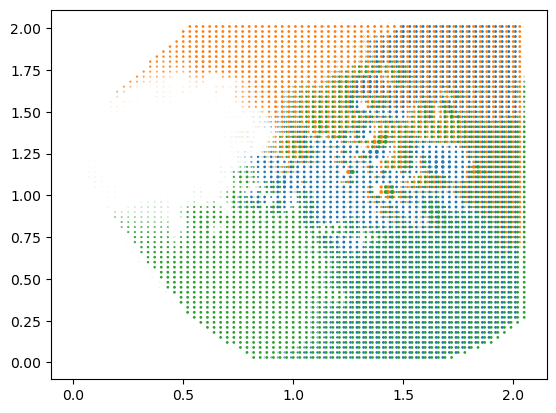

In [145]:
def flatten(mtrx):
    return mtrx.reshape((mtrx.shape[0]*mtrx.shape[1],-1)).squeeze()
    
def get_idx_grid(width,height,step):
    x_idx, y_idx = torch.meshgrid(torch.arange(start=0,end=width-1+step,step=step), torch.arange(start=0,end=height-1+step,step=step), indexing='ij')
    grid_idx = torch.stack([x_idx,y_idx],dim=-1)
    return flatten(grid_idx)

def interpolate_activation(step,activations,method="linear"):
    fine_grid = get_idx_grid(3,3,step)
    fine_act = scipy.interpolate.griddata(pca, necs, fine_grid.numpy(),method=method,fill_value=0)
    return fine_grid.numpy(), torch.FloatTensor(fine_act).numpy()
    
fgrid, fact = interpolate_activation(.03,necs,method="cubic")
print(fgrid.shape)
print(fact.shape)

def thresh(val,minv):
    return np.where(val>minv,val,0)
    

for i in range(fact.shape[1]):
    eps = 2e-2
    # Like a little tv
    nfg = fgrid+[i*eps,0]
    plt.scatter(nfg[:,0],nfg[:,1],s=thresh(fact[:,i],1e-5))
plt.show()


In [157]:
pca.min(axis=0), pca.max(axis=0)
# Its square?

(array([0., 0.], dtype=float32), array([2.6519182, 2.5758414], dtype=float32))